# 주식 데이터 기반 딥러닝 예측 프로젝트

#### 프로젝트 목적
- 이 프로젝트의 목적은 주식 시장 데이터를 활용하여 딥러닝 모델을 통해 주가를 예측하는 것입니다.
- 평가 지표인 **MAE가 가장 낮은 모델, 데이터 전처리 방법을 찾는 것이 목적**입니다.

#### 데이터 개요
- 데이터는 yfinance 라이브러리를 통해 수집되며, 애플(AAPL), 마이크로소프트(MSFT), 테슬라(TSLA) 등 주요 기술 주식과  S&P 500 ETF(SPY), 3배 레버리지 나스닥 100 ETF(TQQQ) 등의 ETF를 포함합니다.
- 데이터는 날짜, 시가, 고가, 저가, 종가, 거래량, 거래 가치를 포함합니다.
#### 데이터 전처리에서 시도해볼 수 있는 것들
 - 정규화: 모델의 성능을 향상시키기 위해 데이터의 스케일을 조정할 수 있습니다.
 - 피처 엔지니어링(Option): 이동 평균, 볼린저 밴드 등 추가적인 피처를 생성하여 모델의 입력으로 사용할 수 있습니다.
#### 모델링 시 시도해볼 수 있는 것들
 - 다양한 딥러닝 아키텍처: RNN, LSTM, GRU 등 다양한 모델을 시도하여 성능을 비교할 수 있습니다.
 - 하이퍼파라미터 튜닝: 하이퍼파라미터를 조정하여 모델의 성능을 최적화할 수 있습니다.
#### 사용해야 할 평가 지표
 - MAE, MSE

---

In [1]:
# !pip install yfinance tqdm scikit-learn -q

In [1]:
import torch

# GPU가 사용 가능한지 확인
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"using GPU: {torch.cuda.get_device_name(0)}")

    # 성능 최적화를 위해 설정
    torch.backends.cudnn.benchmark = True
    torch.cuda.empty_cache() # 불필요한 캐시 메모리 해제

    # 현재 GPU 메모리 사용량 출력
    print(f"Allocated Memory: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")
    print(f"Cached Memory: {torch.cuda.memory_reserved(device) / 1024**2:.2f} MB")
else:
    print("GPU is not available, using CPU.")

using GPU: NVIDIA GeForce RTX 4090
Allocated Memory: 0.00 MB
Cached Memory: 0.00 MB


# 데이터 수집

In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

tickers = [
    "AAPL",  # 애플
    "MSFT",  # 마이크로소프트
    "SPY",   # S&P 500 ETF
    "TSLA",  # 테슬라
    "INTC",  # 인텔
    "NVDA",  # 엔비디아
    "AMZN",  # 아마존
    "META",  # 메타
    "AMD",   # AMD
    "TQQQ"   # 3배 레버리지 나스닥 100 ETF
]

In [3]:
# 각 기업의 주가와 거래량 데이터 가져오기
from tqdm import tqdm

# 데이터를 저장할 리스트 생성
data_list = []

for ticker in tqdm(tickers, desc="데이터 수집 중"):
    stock = yf.Ticker(ticker)
    # 모든 기간의 데이터 가져오기
    df = stock.history(period="max")
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

    # 거래대금 계산 (종가 * 거래량)
    df['Trading_Value'] = df['Close'] * df['Volume']
    df['Ticker'] = ticker

    data_list.append(df)

# 모든 데이터프레임을 하나로 합치기
all_data = pd.concat(data_list, axis=0)
# 인덱스 재설정
all_data = all_data.reset_index()

데이터 수집 중: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


In [4]:
all_data

,Date,Open,High,Low,Close,Volume,Trading_Value,Ticker
0,1980-12-12 00:00:00-05:00,0.098834,0.099264,0.098834,0.098834,469033600,4.635669e+07,AAPL
1,1980-12-15 00:00:00-05:00,0.094108,0.094108,0.093678,0.093678,175884800,1.647658e+07,AAPL
2,1980-12-16 00:00:00-05:00,0.087232,0.087232,0.086802,0.086802,105728000,9.177449e+06,AAPL
3,1980-12-17 00:00:00-05:00,0.088951,0.089381,0.088951,0.088951,86441600,7.689055e+06,AAPL
4,1980-12-18 00:00:00-05:00,0.091530,0.091959,0.091530,0.091530,73449600,6.722825e+06,AAPL
...,...,...,...,...,...,...,...,...
75758,2025-01-27 00:00:00-05:00,77.580002,81.029999,77.180000,79.139999,80910800,6.403281e+09,TQQQ
75759,2025-01-28 00:00:00-05:00,79.580002,83.169998,78.000000,82.650002,50516700,4.175205e+09,TQQQ
75760,2025-01-29 00:00:00-05:00,82.910004,82.980003,80.260002,82.139999,59240600,4.866023e+09,TQQQ
75761,2025-01-30 00:00:00-05:00,83.470001,84.589996,80.860001,83.169998,57585500,4.789386e+09,TQQQ


### 결측치 확인

In [5]:
# 결측치 확인
print("전체 결측치 개수:")
all_data.isnull().sum()

전체 결측치 개수:


Date             0
Open             0
High             0
Low              0
Close            0
Volume           0
Trading_Value    0
Ticker           0
dtype: int64

# 윈도우 데이터 생성

In [31]:
%%time
import numpy as np

def create_window_data_and_targets(df, window_size, step_size=2):
    """
    각 종목별로 주가 데이터를 윈도우 슬라이딩하여 입력(X)와 타깃(y)을 생성합니다.
    타깃은 윈도우 바로 뒤의 'Close'(종가) 값로 설정합니다.
    """
    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Trading_Value']
    df = df.sort_values(by=['Date'])
    
    X_windows = []
    y_targets = []
    
    # 각 티커별로 처리
    for ticker in df['Ticker'].unique():
        stock_df = df[df['Ticker'] == ticker].copy()
        stock_df = stock_df[feature_columns]
        # 슬라이딩 윈도우 (예, 30일 입력 → 다음 날 종가 예측)
        for i in range(0, len(stock_df) - window_size, step_size):
            window = stock_df.iloc[i : i + window_size].values
            target = stock_df.iloc[i + window_size]['Close']  # 다음 거래일 종가
            X_windows.append(window)
            y_targets.append(target)
    
    return np.array(X_windows), np.array(y_targets)

# 윈도우 크기 및 간격 설정
window_size = 30
step_size = 2
X, y = create_window_data_and_targets(all_data, window_size, step_size)
print("생성된 입력 X 형태:", X.shape)  # (샘플 수, 30, 6)
print("생성된 타깃 y 형태:", y.shape)   # (샘플 수,)

생성된 입력 X 형태: (37735, 30, 6)
생성된 타깃 y 형태: (37735,)
CPU times: total: 3.23 s
Wall time: 3.24 s


# 데이터 전처리

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# (샘플 수, 윈도우 크기, 피처 수) → 2D로 reshape 후 스케일링
num_samples, seq_len, num_features = X.shape
X_reshaped = X.reshape(-1, num_features)
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, seq_len, num_features)

# 타깃 스케일링 (타깃은 1차원 배열이므로 2D 변환 후 스케일링)
y = y.reshape(-1, 1)
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y).flatten()  # 다시 1D로 변환

# 모델 정의

### 학습/검증/테스트 분할 및 PyTorch Dataset 구성

In [34]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

import torch
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_dataset = StockDataset(X_train, y_train)
val_dataset = StockDataset(X_val, y_val)
test_dataset = StockDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("학습에 사용할 device:", device)

학습에 사용할 device: cuda


# PyTorch 모델 구현

### RNN 모델

In [35]:
import torch.nn as nn

# (1) RNN 모델
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # x: [batch, seq, input_size]
        out, _ = self.rnn(x)  # out: [batch, seq, hidden_size]
        out = out[:, -1, :]   # 마지막 타임스텝의 은닉 상태 사용
        out = self.fc(out)
        return out

### LSTM

In [36]:
# (2) LSTM 모델
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

### GRU

In [37]:
# (3) GRU 모델
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

### Trnasformer

In [38]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_heads, dropout):
        super(TransformerModel, self).__init__()
        self.input_linear = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size,
                                                   nhead=num_heads,
                                                   dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # x: [batch, seq, input_size]
        x = self.input_linear(x)     # → [batch, seq, hidden_size]
        x = x.permute(1, 0, 2)         # Transformer는 [seq, batch, hidden_size] 입력 필요
        out = self.transformer(x)      # → [seq, batch, hidden_size]
        out = out[-1, :, :]            # 마지막 타임스텝 사용
        out = self.fc(out)
        return out

# 학습 및 평가 함수 정의

In [40]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device):
    model.to(device)
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # 검증 단계
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.unsqueeze(1))
                running_val_loss += loss.item() * X_batch.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    
    return train_losses, val_losses

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model(model, test_loader, device, target_scaler):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds.extend(outputs.squeeze(1).cpu().numpy())
            targets.extend(y_batch.numpy())
    preds = np.array(preds).reshape(-1, 1)
    targets = np.array(targets).reshape(-1, 1)
    # inverse scaling to 원래 단위로 복원
    preds_inv = target_scaler.inverse_transform(preds)
    targets_inv = target_scaler.inverse_transform(targets)
    mae = mean_absolute_error(targets_inv, preds_inv)
    mse = mean_squared_error(targets_inv, preds_inv)
    return mae, mse, preds_inv, targets_inv

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()  # 평가 모드
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch).squeeze()
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    return mse, mae


# 모델 학습 및 평가 실행

In [42]:
# 하이퍼파라미터 설정
input_size = num_features    # 6
hidden_size = 64
num_layers = 2
dropout = 0.2
num_epochs = 10     # 데모용 (실제 학습에서는 에포크 수를 늘릴 수 있음)
learning_rate = 0.001

# 모델별 객체 생성
models = {
    "RNN": RNNModel(input_size, hidden_size, num_layers, dropout),
    "LSTM": LSTMModel(input_size, hidden_size, num_layers, dropout),
    "GRU": GRUModel(input_size, hidden_size, num_layers, dropout),
    "Transformer": TransformerModel(input_size, hidden_size, num_layers, num_heads=4, dropout=dropout)
}

results = {}

for model_name, model in models.items():
    print(f"\n===== {model_name} 모델 학습 시작 =====")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    train_losses, val_losses = train_model(model, train_loader, val_loader,
                                           num_epochs, criterion, optimizer, device)
    mae, mse, preds_inv, targets_inv = evaluate_model(model, test_loader, device, target_scaler)
    print(f"{model_name} 모델 평가 → Test MAE: {mae:.4f}, Test MSE: {mse:.4f}")
    results[model_name] = {
        "mae": mae,
        "mse": mse,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "preds": preds_inv,
        "targets": targets_inv
    }

c:\Users\user\anaconda3\envs\supernova\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



===== RNN 모델 학습 시작 =====
Epoch 1/10 | Train Loss: 0.0273 | Val Loss: 0.0019
Epoch 2/10 | Train Loss: 0.0047 | Val Loss: 0.0039
Epoch 3/10 | Train Loss: 0.0041 | Val Loss: 0.0035
Epoch 4/10 | Train Loss: 0.0034 | Val Loss: 0.0031
Epoch 5/10 | Train Loss: 0.0032 | Val Loss: 0.0009
Epoch 6/10 | Train Loss: 0.0025 | Val Loss: 0.0014
Epoch 7/10 | Train Loss: 0.0029 | Val Loss: 0.0010
Epoch 8/10 | Train Loss: 0.0023 | Val Loss: 0.0017
Epoch 9/10 | Train Loss: 0.0024 | Val Loss: 0.0015
Epoch 10/10 | Train Loss: 0.0027 | Val Loss: 0.0011
RNN 모델 평가 → Test MAE: 1.9537, Test MSE: 8.0776

===== LSTM 모델 학습 시작 =====
Epoch 1/10 | Train Loss: 0.0407 | Val Loss: 0.0029
Epoch 2/10 | Train Loss: 0.0031 | Val Loss: 0.0019
Epoch 3/10 | Train Loss: 0.0025 | Val Loss: 0.0020
Epoch 4/10 | Train Loss: 0.0026 | Val Loss: 0.0018
Epoch 5/10 | Train Loss: 0.0026 | Val Loss: 0.0016
Epoch 6/10 | Train Loss: 0.0021 | Val Loss: 0.0017
Epoch 7/10 | Train Loss: 0.0022 | Val Loss: 0.0013
Epoch 8/10 | Train Loss: 0.0021 

# 학습 곡선 및 예측 결과 시각화

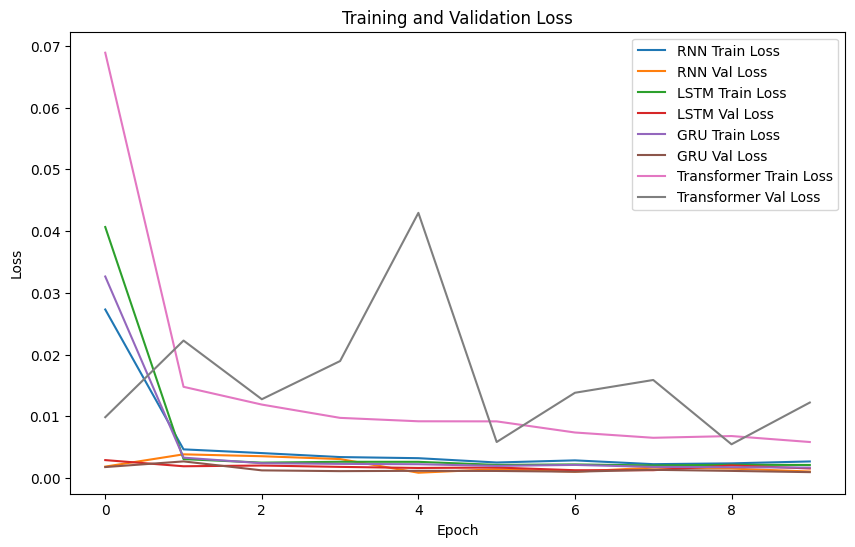

In [43]:
import matplotlib.pyplot as plt

# 모델별 학습/검증 손실 곡선
plt.figure(figsize=(10, 6))
for model_name, res in results.items():
    plt.plot(res["train_losses"], label=f"{model_name} Train Loss")
    plt.plot(res["val_losses"], label=f"{model_name} Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

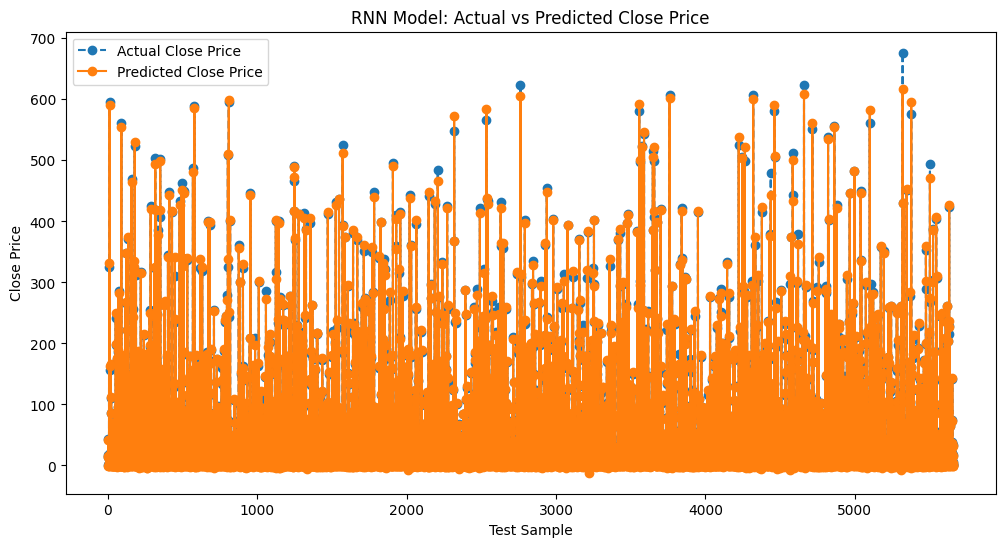

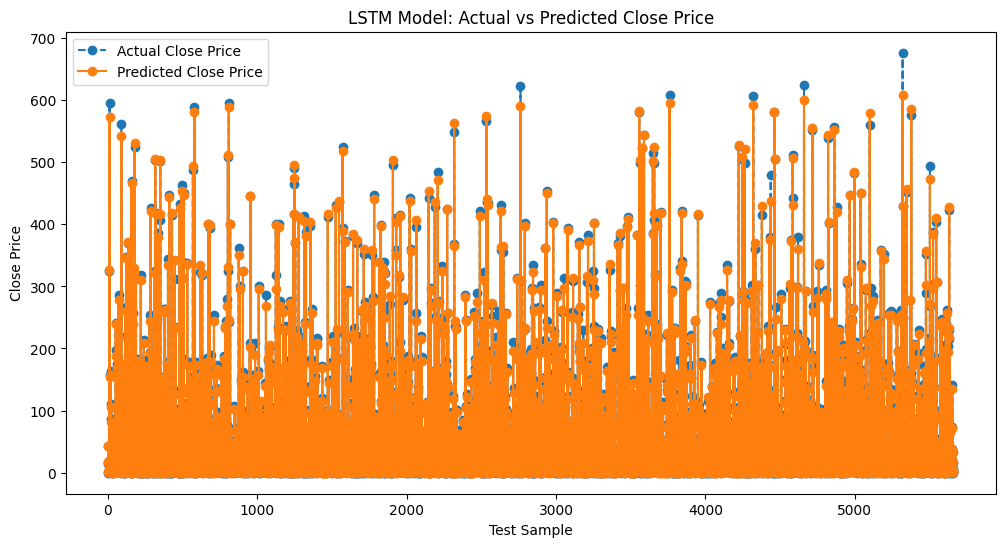

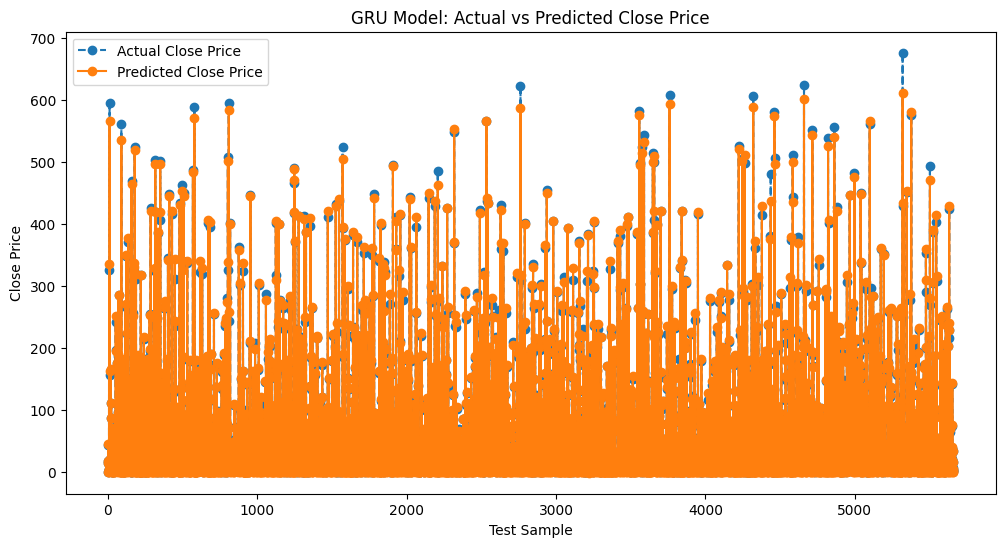

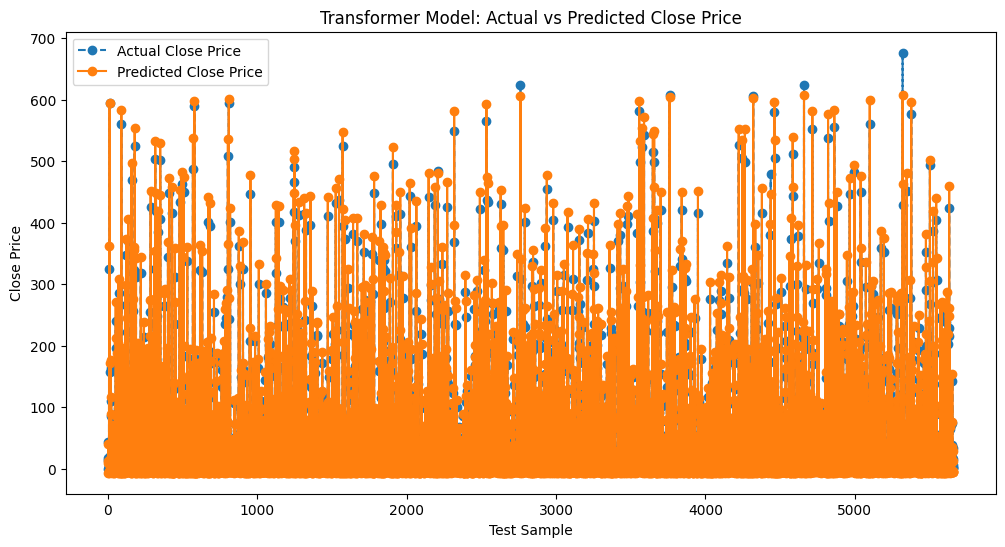

In [45]:
import matplotlib.pyplot as plt

# 모델별 예측 vs 실제 타깃 시각화
for model_name, res in results.items():
    plt.figure(figsize=(12, 6))
    plt.plot(res["targets"], label="Actual Close Price", marker='o', linestyle='--')
    plt.plot(res["preds"], label="Predicted Close Price", marker='o', linestyle='-')
    plt.xlabel("Test Sample")
    plt.ylabel("Close Price")
    plt.title(f"{model_name} Model: Actual vs Predicted Close Price")
    plt.legend()
    plt.show()
